## 신용카드 사용자 연체 예측 AI 경진대회

### 데이터 변수
 - gender: 성별
 - car: 차량 소유 여부
 - reality : 부동산 소유 여부
 - child num: 자녀 수
 - income_total : 연간 소득
 - income_type : 소득 분류=> ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
 - edu_type : 교육 수준 => ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
 - family_type: 결혼 여부 => ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
 - house_type: 생활방식 => ['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']
 - day_birth: 출생일 =>-1은 데이터 수집일 하루 전 출생,데이터수집당시 0으로부터 역으로 셈(하루단위)
 - day_employed: 업무 시작일. 하루단위로 계산. 양수는 고용x
 - flag_mobil: 휴대폰 소유 여부
 - work_phone: 업무용 전화 소유 여부
 - phone: 전화 소유 여부
 - email: 이메일 소유 여부
 - occyp_type: 직업 유형
 - family_size: 가족 규모
 - begin_month: 신용카드 발급월

종속변수 (credit) : 사용자의 신용카드 대금 연체를 기준으로 한 신용도. 낮을수록 높은 신용의 신용카드 사용자를 의미

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import plot_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

In [2]:
train=pd.read_csv('/content/sample_data/train.csv')
test=pd.read_csv('/content/sample_data/test.csv')
submit=pd.read_csv('/content/sample_data/sample_submission.csv')
df_train=train.copy()
df_test=test.copy()

In [3]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [4]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [5]:
print(train.shape,test.shape)

(26457, 20) (10000, 19)


In [6]:
train.info() #occyp_type만 결측값 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

### 결측치 확인

In [7]:
#결측치 제거
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

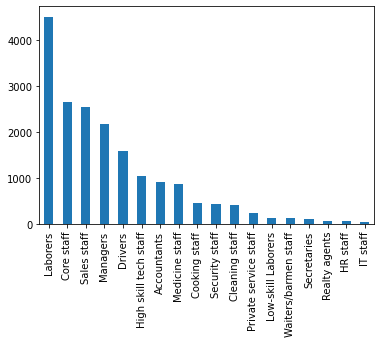

In [8]:
train['occyp_type'].value_counts().plot(kind='bar')
#laborers가 많은 편. core staff, sales staff,managers,drivers 순으로 나타남
#노동자들이 많은 타입

In [9]:
train['occyp_type'].value_counts()

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

## EDA

### 결측치 분석

In [10]:
non_occyp=df_train.loc[df_train['occyp_type'].isnull()]#직업유형이 없는 사람
occyp=df_train.dropna()#직업유형이 있는 사람(결측치 제거)

In [11]:
non_occyp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8171 entries, 0 to 26453
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          8171 non-null   int64  
 1   gender         8171 non-null   object 
 2   car            8171 non-null   object 
 3   reality        8171 non-null   object 
 4   child_num      8171 non-null   int64  
 5   income_total   8171 non-null   float64
 6   income_type    8171 non-null   object 
 7   edu_type       8171 non-null   object 
 8   family_type    8171 non-null   object 
 9   house_type     8171 non-null   object 
 10  DAYS_BIRTH     8171 non-null   int64  
 11  DAYS_EMPLOYED  8171 non-null   int64  
 12  FLAG_MOBIL     8171 non-null   int64  
 13  work_phone     8171 non-null   int64  
 14  phone          8171 non-null   int64  
 15  email          8171 non-null   int64  
 16  occyp_type     0 non-null      object 
 17  family_size    8171 non-null   float64
 18  begin_m

In [12]:
non_occyp.head() #occyp_type이 없는 사람

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
8,8,M,Y,Y,1,180000.0,Commercial associate,Higher education,Married,House / apartment,-15131,-1466,1,0,0,1,NaN,3.0,-38.0,2.0
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,1,0,1,0,NaN,1.0,-41.0,2.0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,NaN,2.0,-37.0,2.0
19,19,F,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-13727,-6031,1,0,0,0,NaN,2.0,-7.0,2.0


In [13]:
occyp.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
5,5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,-13413,-4996,1,0,0,1,High skill tech staff,4.0,-18.0,1.0


In [14]:
occyp.loc[occyp['DAYS_EMPLOYED']>0]#1이 없음
#전부다 고용된 상태임

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit


In [15]:
non_occyp['DAYS_EMPLOYED'].value_counts()
#양수인 부분이 4438개->고용된 사람과 그렇지 않은 사람이 존재한다.

 365243    4438
-302         25
-1613        21
-2014        21
-3079        21
           ... 
-873          1
-4029         1
-825          1
-3608         1
-2051         1
Name: DAYS_EMPLOYED, Length: 963, dtype: int64

In [16]:
non_occyp['employeed']=[1 if t<0 else 0 for t in list(non_occyp['DAYS_EMPLOYED'])]

In [17]:
non_occyp.head()#양수면 0,음수면 1

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0,1
8,8,M,Y,Y,1,180000.0,Commercial associate,Higher education,Married,House / apartment,-15131,-1466,1,0,0,1,NaN,3.0,-38.0,2.0,1
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,1,0,1,0,NaN,1.0,-41.0,2.0,0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,NaN,2.0,-37.0,2.0,0
19,19,F,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-13727,-6031,1,0,0,0,NaN,2.0,-7.0,2.0,1


In [18]:
occyp['employeed']=1

In [19]:
occyp.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,1
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,1
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,1
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,1
5,5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,-13413,-4996,1,0,0,1,High skill tech staff,4.0,-18.0,1.0,1


결측치에 해당하는 값을 조사한 결과 고용이 안 된 사람과 된 사람 모두 포함되지만 결측값이 없는 상태는 모두 고용이 된 사람들이다.

In [20]:
#결측값 중 고용된 사람 중에서 소득분류 분포
non_occyp.loc[non_occyp['employeed']==1]['income_type'].value_counts()

Working                 2312
Commercial associate    1026
State servant            392
Pensioner                  2
Student                    1
Name: income_type, dtype: int64

일하는 사람은 2312,상업 제휴를 하는 사람은 1026,공무원은 392,학생은 1명,연금수령자는 2명(2명은 정년퇴직?)

In [21]:
non_occyp.loc[non_occyp['DAYS_EMPLOYED']>=0]['income_type'].value_counts()
#고용되지 않은 사람 중에는 연금을 수령한 사람들이다.

Pensioner    4438
Name: income_type, dtype: int64

In [22]:
print(occyp.shape,non_occyp.shape)

(18286, 21) (8171, 21)


In [23]:
non_occyp.loc[(non_occyp['employeed']==0)] #4438개,고용되지 않은 사람 수

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,1,0,1,0,NaN,1.0,-41.0,2.0,0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,NaN,2.0,-37.0,2.0,0
21,21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21253,365243,1,0,1,0,NaN,2.0,-7.0,2.0,0
24,24,F,N,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22361,365243,1,0,1,0,NaN,1.0,-5.0,2.0,0
46,46,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21100,365243,1,0,1,0,NaN,1.0,-24.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,26431,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21151,365243,1,0,0,1,NaN,1.0,-60.0,1.0,0
26432,26432,F,Y,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22314,365243,1,0,1,0,NaN,2.0,-17.0,1.0,0
26439,26439,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19238,365243,1,0,0,0,NaN,2.0,-57.0,2.0,0
26441,26441,F,N,Y,0,90000.0,Pensioner,Incomplete higher,Separated,House / apartment,-24129,365243,1,0,0,0,NaN,1.0,-43.0,2.0,0


In [24]:
non_occyp.loc[(non_occyp['employeed']==0),'occyp_type']='inocc'
#고용되지 않은 사람은 inocc로 처리.

In [25]:
non_occyp.loc[(non_occyp['employeed']==0),'DAYS_EMPLOYED']=0

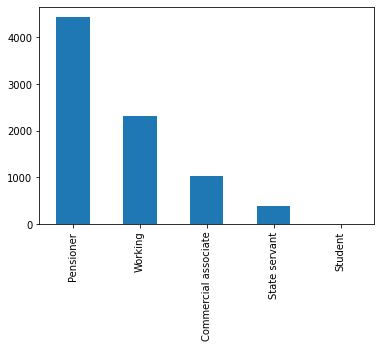

In [26]:
non_occyp['income_type'].value_counts().plot(kind='bar')
#결측치가 들어간 데이터 내 소득 분류는 연금을 받은 사람들이 많다.

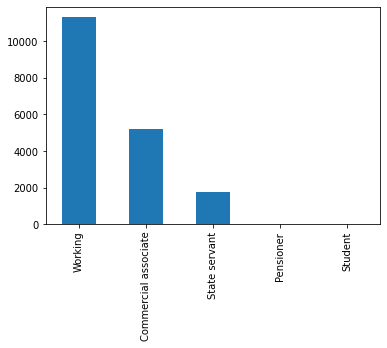

In [27]:
occyp['income_type'].value_counts().plot(kind='bar')
#역시 연금을 받은 사람이 많다.

In [28]:
non_occyp.loc[non_occyp['income_type']=='Pensioner']
#연금을 받는 사람들 대상으로 조사 결과 income_total은 결측치가 없다

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,0,1,0,1,0,inocc,1.0,-41.0,2.0,0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,0,1,0,0,0,inocc,2.0,-37.0,2.0,0
21,21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21253,0,1,0,1,0,inocc,2.0,-7.0,2.0,0
24,24,F,N,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22361,0,1,0,1,0,inocc,1.0,-5.0,2.0,0
46,46,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21100,0,1,0,1,0,inocc,1.0,-24.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,26431,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21151,0,1,0,0,1,inocc,1.0,-60.0,1.0,0
26432,26432,F,Y,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22314,0,1,0,1,0,inocc,2.0,-17.0,1.0,0
26439,26439,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19238,0,1,0,0,0,inocc,2.0,-57.0,2.0,0
26441,26441,F,N,Y,0,90000.0,Pensioner,Incomplete higher,Separated,House / apartment,-24129,0,1,0,0,0,inocc,1.0,-43.0,2.0,0


In [29]:
non_occyp.isnull().sum() #3733개 남음

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3733
family_size         0
begin_month         0
credit              0
employeed           0
dtype: int64

In [30]:
non_occyp.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0,1
8,8,M,Y,Y,1,180000.0,Commercial associate,Higher education,Married,House / apartment,-15131,-1466,1,0,0,1,NaN,3.0,-38.0,2.0,1
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,0,1,0,1,0,inocc,1.0,-41.0,2.0,0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,0,1,0,0,0,inocc,2.0,-37.0,2.0,0
19,19,F,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-13727,-6031,1,0,0,0,NaN,2.0,-7.0,2.0,1


In [31]:
occyp.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,1
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,1
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,1
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,1
5,5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,-13413,-4996,1,0,0,1,High skill tech staff,4.0,-18.0,1.0,1


### regression

In [32]:
data=pd.concat([occyp,non_occyp])

In [33]:
data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,1
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,1
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,1
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,1
5,5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,-13413,-4996,1,0,0,1,High skill tech staff,4.0,-18.0,1.0,1


In [34]:
#명목형 변수 라벨화
label_encoder=preprocessing.LabelEncoder()
data['gender'] = data['gender'].replace(['F','M'],[0,1])
data['car'] = data['car'].replace(['N','Y'],[0,1])
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
data['income_type']=label_encoder.fit_transform(data['income_type'])
#################################################################
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
########################################################################
data['family_type']=label_encoder.fit_transform(data['family_type'])
########################################################################
data['house_type']=label_encoder.fit_transform(data['house_type'])
########################################################################

In [35]:
data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
1,1,0,0,1,1,247500.0,0,4,0,1,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,1
2,2,1,1,1,0,450000.0,4,1,1,1,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,1
3,3,0,0,1,0,202500.0,0,4,1,1,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,1
4,4,0,1,1,0,157500.0,2,1,1,1,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,1
5,5,0,0,1,2,270000.0,4,4,1,1,-13413,-4996,1,0,0,1,High skill tech staff,4.0,-18.0,1.0,1


In [36]:
null_data=data.loc[data['occyp_type'].isnull()]

In [37]:
null_data.head()#inocc 대체 후 결측치가 있는 것들

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
0,0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0,1
8,8,1,1,1,1,180000.0,0,1,1,1,-15131,-1466,1,0,0,1,NaN,3.0,-38.0,2.0,1
19,19,0,0,1,0,180000.0,4,4,1,1,-13727,-6031,1,0,0,0,NaN,2.0,-7.0,2.0,1
20,20,1,0,0,0,180000.0,4,4,1,1,-19850,-1753,1,0,1,0,NaN,2.0,-35.0,2.0,1
23,23,1,1,0,0,225000.0,4,4,1,2,-14542,-444,1,1,1,1,NaN,2.0,-18.0,2.0,1


In [38]:
data.shape

(26457, 21)

In [39]:
fill_data=data.dropna() #결측치 제거한 데이터

In [40]:
print(fill_data.shape,null_data.shape)

(22724, 21) (3733, 21)


In [41]:
fill_data['occyp_type_l']=label_encoder.fit_transform(fill_data['occyp_type'])
#결측치 없는 데이터 중 occyp_type를 라벨링한 변수를 추가(라벨링과 원래값 비교를 위해)

In [42]:
fill_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed,occyp_type_l
1,1,0,0,1,1,247500.0,0,4,0,1,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,1,8
2,2,1,1,1,0,450000.0,4,1,1,1,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,1,10
3,3,0,0,1,0,202500.0,0,4,1,1,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,1,14
4,4,0,1,1,0,157500.0,2,1,1,1,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,1,10
5,5,0,0,1,2,270000.0,4,4,1,1,-13413,-4996,1,0,0,1,High skill tech staff,4.0,-18.0,1.0,1,6


In [43]:
fill_data.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit', 'employeed',
       'occyp_type_l'],
      dtype='object')

In [44]:
null_data.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit', 'employeed'],
      dtype='object')

In [45]:
lin_reg = linear_model.LinearRegression()
x=fill_data[fill_data.columns.drop(['index','occyp_type','credit',
                                   'employeed','occyp_type_l'])]
#employeed(0,1)을 넣지 않고 days_employed에서 양수값을 0으로 처리한 상태에서 재시도
#라벨링한 occyp_type_l는 종속변수로 사용
y=fill_data['occyp_type_l']#라벨링 상태
lin_reg_model = lin_reg.fit(x, y)

In [46]:
x.shape

(22724, 17)

In [47]:
x_test=null_data[null_data.columns.drop(['index','occyp_type','credit','employeed'])]
y_test=null_data['occyp_type']
y_test=lin_reg.predict(x_test)#결측치가 있는 데이터에 대입

In [48]:
null_data['occyp_type']=y_test

In [49]:
null_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
0,0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709,1,0,0,0,7.789922,2.0,-6.0,1.0,1
8,8,1,1,1,1,180000.0,0,1,1,1,-15131,-1466,1,0,0,1,8.832769,3.0,-38.0,2.0,1
19,19,0,0,1,0,180000.0,4,4,1,1,-13727,-6031,1,0,0,0,6.110326,2.0,-7.0,2.0,1
20,20,1,0,0,0,180000.0,4,4,1,1,-19850,-1753,1,0,1,0,11.776212,2.0,-35.0,2.0,1
23,23,1,1,0,0,225000.0,4,4,1,2,-14542,-444,1,1,1,1,7.800152,2.0,-18.0,2.0,1


In [50]:
null_data.shape

(3733, 21)

In [51]:
null_data['occyp_type'].value_counts() 

5.421080     4
6.700081     4
3.093324     3
10.643064    3
6.600869     3
            ..
4.394048     1
8.236410     1
4.992975     1
9.941356     1
9.905188     1
Name: occyp_type, Length: 3357, dtype: int64

In [52]:
print(y[:10]) 

1      8
2     10
3     14
4     10
5      6
6      3
7      4
9     11
10     8
11    10
Name: occyp_type_l, dtype: int64


In [53]:
fill_data['occyp_type'].value_counts()

Laborers                 4512
inocc                    4438
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [54]:
#fill_data['occyp_type_enc']=y_encoded
fill_data['occyp_type_l'].value_counts()

8     4512
18    4438
3     2646
14    2539
10    2167
4     1575
6     1040
0      902
11     864
2      457
16     424
1      403
12     243
9      127
17     124
15      97
13      63
5       62
7       41
Name: occyp_type_l, dtype: int64

In [55]:
fill_data['occyp_type_l'].unique()#라벨링값

array([ 8, 10, 14,  6,  3,  4, 11,  0, 13, 16,  1, 12,  2, 15,  5,  7,  9,
       17, 18])

In [56]:
fill_data['occyp_type'].unique()#라벨링값 순서대로 8:Laborers,10:Managers,...

array(['Laborers', 'Managers', 'Sales staff', 'High skill tech staff',
       'Core staff', 'Drivers', 'Medicine staff', 'Accountants',
       'Realty agents', 'Security staff', 'Cleaning staff',
       'Private service staff', 'Cooking staff', 'Secretaries',
       'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff', 'inocc'], dtype=object)

### 버림

In [58]:
y_test

array([7.78992235, 8.83276897, 6.11032588, ..., 6.98451747, 6.62673355,
       7.92269725])

In [59]:
np.trunc(y_test)

array([7., 8., 6., ..., 6., 6., 7.])

In [60]:
null_data['occyp_type']=np.trunc(null_data['occyp_type'])

In [61]:
null_data['occyp_type'].describe()

count    3733.000000
mean        7.790249
std         2.370028
min         2.000000
25%         6.000000
50%         8.000000
75%         9.000000
max        15.000000
Name: occyp_type, dtype: float64

In [62]:
null_data['occyp_type'].value_counts()

7.0     584
8.0     580
6.0     544
9.0     437
5.0     430
10.0    398
11.0    270
4.0     163
12.0    136
13.0     78
3.0      73
14.0     35
15.0      3
2.0       2
Name: occyp_type, dtype: int64

In [63]:
#라벨링->원래값
null_data.loc[null_data['occyp_type']==2.0,'occyp_type']= 'Cooking staff'
null_data.loc[null_data['occyp_type']==3.0,'occyp_type']='Core staff'
null_data.loc[null_data['occyp_type']==4.0,'occyp_type']='Drivers'
null_data.loc[null_data['occyp_type']==5.0,'occyp_type']='HR staff'
null_data.loc[null_data['occyp_type']==6.0,'occyp_type']='High skill tech staff'
null_data.loc[null_data['occyp_type']==7.0,'occyp_type']='IT staff'
null_data.loc[null_data['occyp_type']==8.0,'occyp_type']='Laborers'
null_data.loc[null_data['occyp_type']==9.0,'occyp_type']='Low-skill Laborers'
null_data.loc[null_data['occyp_type']==10.0,'occyp_type']='Managers'
null_data.loc[null_data['occyp_type']==11.0,'occyp_type']='Medicine staff'
null_data.loc[null_data['occyp_type']==12.0,'occyp_type']='Private service staff'
null_data.loc[null_data['occyp_type']==13.0,'occyp_type']='Realty agents'
null_data.loc[null_data['occyp_type']==14.0,'occyp_type']='Sales staff'
null_data.loc[null_data['occyp_type']==15.0,'occyp_type']='Secretaries'
null_data.loc[null_data['occyp_type']==16.0,'occyp_type']='Security staff'

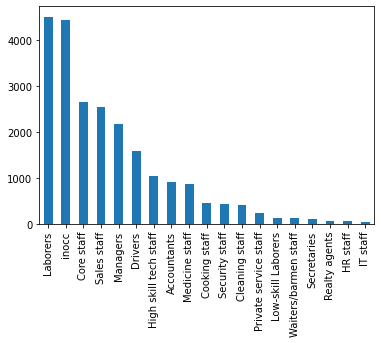

In [64]:
fill_data['occyp_type'].value_counts().plot(kind='bar')

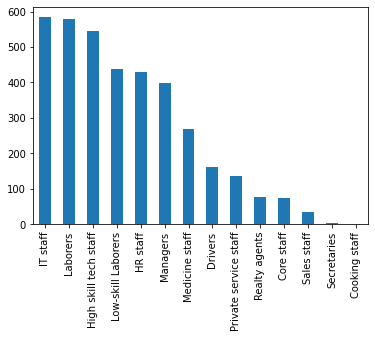

In [65]:
null_data['occyp_type'].value_counts().plot(kind='bar')

In [66]:
null_data.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit', 'employeed'],
      dtype='object')

In [67]:
fill_data.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit', 'employeed',
       'occyp_type_l'],
      dtype='object')

In [68]:
fill_data=fill_data.drop('occyp_type_l',axis=1)

In [69]:
df=pd.concat([null_data,fill_data]).sort_values(by='index')
df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
0,0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709,1,0,0,0,IT staff,2.0,-6.0,1.0,1
1,1,0,0,1,1,247500.0,0,4,0,1,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,1
2,2,1,1,1,0,450000.0,4,1,1,1,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,1
3,3,0,0,1,0,202500.0,0,4,1,1,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,1
4,4,0,1,1,0,157500.0,2,1,1,1,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,1


In [70]:
null_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employeed
0,0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709,1,0,0,0,IT staff,2.0,-6.0,1.0,1
8,8,1,1,1,1,180000.0,0,1,1,1,-15131,-1466,1,0,0,1,Laborers,3.0,-38.0,2.0,1
19,19,0,0,1,0,180000.0,4,4,1,1,-13727,-6031,1,0,0,0,High skill tech staff,2.0,-7.0,2.0,1
20,20,1,0,0,0,180000.0,4,4,1,1,-19850,-1753,1,0,1,0,Medicine staff,2.0,-35.0,2.0,1
23,23,1,1,0,0,225000.0,4,4,1,2,-14542,-444,1,1,1,1,IT staff,2.0,-18.0,2.0,1


### test파일 전처리

In [71]:
df_test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          10000 non-null  int64  
 1   gender         10000 non-null  object 
 2   car            10000 non-null  object 
 3   reality        10000 non-null  object 
 4   child_num      10000 non-null  int64  
 5   income_total   10000 non-null  float64
 6   income_type    10000 non-null  object 
 7   edu_type       10000 non-null  object 
 8   family_type    10000 non-null  object 
 9   house_type     10000 non-null  object 
 10  DAYS_BIRTH     10000 non-null  int64  
 11  DAYS_EMPLOYED  10000 non-null  int64  
 12  FLAG_MOBIL     10000 non-null  int64  
 13  work_phone     10000 non-null  int64  
 14  phone          10000 non-null  int64  
 15  email          10000 non-null  int64  
 16  occyp_type     6848 non-null   object 
 17  family_size    10000 non-null  float64
 18  begin_m

In [72]:
df_test.isnull().sum() #결측치 3152

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

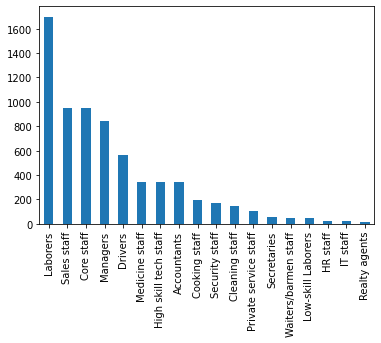

In [73]:
df_test['occyp_type'].value_counts().plot(kind='bar')
#laborers가 많은 편. sales staff,core staff,managers,drivers 순으로 나타남
#노동자들이 많은 타입

In [74]:
df_test['occyp_type'].value_counts()

Laborers                 1699
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
Medicine staff            343
High skill tech staff     343
Accountants               339
Cooking staff             198
Security staff            168
Cleaning staff            148
Private service staff     101
Secretaries                54
Waiters/barmen staff       50
Low-skill Laborers         48
HR staff                   23
IT staff                   19
Realty agents              16
Name: occyp_type, dtype: int64

In [75]:
df_test.loc[df_test['DAYS_EMPLOYED']>0,'DAYS_EMPLOYED']=0

In [76]:
df_non_occyp=df_test.loc[df_test['occyp_type'].isnull()]#직업유형이 없는 사람
df_occyp=df_test.dropna()#직업유형이 있는 사람(결측치 제거)

In [77]:
df_non_occyp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3152 entries, 0 to 9998
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          3152 non-null   int64  
 1   gender         3152 non-null   object 
 2   car            3152 non-null   object 
 3   reality        3152 non-null   object 
 4   child_num      3152 non-null   int64  
 5   income_total   3152 non-null   float64
 6   income_type    3152 non-null   object 
 7   edu_type       3152 non-null   object 
 8   family_type    3152 non-null   object 
 9   house_type     3152 non-null   object 
 10  DAYS_BIRTH     3152 non-null   int64  
 11  DAYS_EMPLOYED  3152 non-null   int64  
 12  FLAG_MOBIL     3152 non-null   int64  
 13  work_phone     3152 non-null   int64  
 14  phone          3152 non-null   int64  
 15  email          3152 non-null   int64  
 16  occyp_type     0 non-null      object 
 17  family_size    3152 non-null   float64
 18  begin_mo

In [78]:
df_occyp.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
5,26462,F,Y,Y,0,126000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-18458,-2104,1,0,0,0,Core staff,1.0,-5.0


In [79]:
df_occyp.loc[df_occyp['DAYS_EMPLOYED']>0] #모두 고용된 상태

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month


In [80]:
df_non_occyp['DAYS_EMPLOYED'].value_counts()
#양수인 부분은 이미 0으로 전환

 0       1697
-422        9
-7627       9
-3243       9
-3993       9
         ... 
-3933       1
-4509       1
-8071       1
-1662       1
-4082       1
Name: DAYS_EMPLOYED, Length: 678, dtype: int64

In [81]:
df_non_occyp.loc[df_non_occyp['DAYS_EMPLOYED']!=0]['income_type'].value_counts()
#소득분류 분포(고용된 사람 중)

Working                 885
Commercial associate    412
State servant           156
Pensioner                 2
Name: income_type, dtype: int64

In [82]:
df_non_occyp.loc[df_non_occyp['DAYS_EMPLOYED']==0]['income_type'].value_counts()
#전원 연금을 받는 사람들이다

Pensioner    1697
Name: income_type, dtype: int64

In [83]:
print(df_occyp.shape,df_non_occyp.shape)

(6848, 19) (3152, 19)


In [84]:
df_non_occyp.loc[(df_non_occyp['DAYS_EMPLOYED']==0),'occyp_type']='inocc'

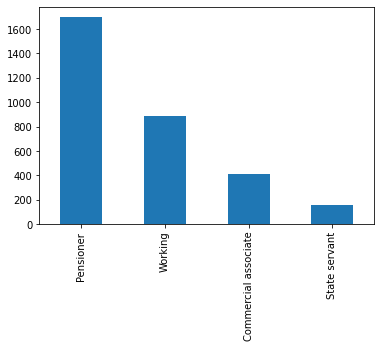

In [85]:
df_non_occyp['income_type'].value_counts().plot(kind='bar')
#결측치가 들어간 데이터 내 소득 분류

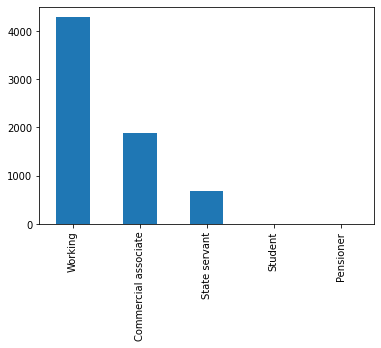

In [86]:
df_occyp['income_type'].value_counts().plot(kind='bar')

In [87]:
df_non_occyp.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       1455
family_size         0
begin_month         0
dtype: int64

In [88]:
test_data=pd.concat([df_non_occyp,df_occyp])

In [89]:
test_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,0,1,0,1,0,inocc,2.0,-60.0
6,26463,F,N,Y,0,585000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18858,-2010,1,0,1,0,NaN,2.0,-1.0
7,26464,F,N,Y,0,141750.0,Pensioner,Higher education,Married,House / apartment,-20345,0,1,0,1,0,inocc,2.0,-10.0
8,26465,F,N,N,0,225000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19316,-4451,1,1,1,0,NaN,1.0,-23.0
10,26467,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21056,0,1,0,1,0,inocc,1.0,-47.0


In [90]:
label_encoder=preprocessing.LabelEncoder()
test_data['gender'] = test_data['gender'].replace(['F','M'],[0,1])
test_data['car'] = test_data['car'].replace(['N','Y'],[0,1])
test_data['reality'] = test_data['reality'].replace(['N','Y'],[0,1])
test_data['income_type']=label_encoder.fit_transform(test_data['income_type'])
#################################################################
test_data['edu_type']=label_encoder.fit_transform(test_data['edu_type'])
########################################################################
test_data['family_type']=label_encoder.fit_transform(test_data['family_type'])

In [91]:
########################################################################
test_data['house_type']=label_encoder.fit_transform(test_data['house_type'])
########################################################################

In [92]:
test_data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,1,1,0,0,112500.0,1,4,0,1,-21990,0,1,0,1,0,inocc,2.0,-60.0
6,26463,0,0,1,0,585000.0,0,4,1,1,-18858,-2010,1,0,1,0,NaN,2.0,-1.0
7,26464,0,0,1,0,141750.0,1,1,1,1,-20345,0,1,0,1,0,inocc,2.0,-10.0
8,26465,0,0,0,0,225000.0,4,4,3,1,-19316,-4451,1,1,1,0,NaN,1.0,-23.0
10,26467,0,0,1,0,90000.0,1,4,4,1,-21056,0,1,0,1,0,inocc,1.0,-47.0


In [93]:
null_data_t=test_data.loc[test_data['occyp_type'].isnull()]
fill_data_t=test_data.dropna()

In [94]:
null_data_t.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
6,26463,0,0,1,0,585000.0,0,4,1,1,-18858,-2010,1,0,1,0,NaN,2.0,-1.0
8,26465,0,0,0,0,225000.0,4,4,3,1,-19316,-4451,1,1,1,0,NaN,1.0,-23.0
38,26495,1,1,0,1,225000.0,4,4,3,1,-13902,-1589,1,0,1,0,NaN,2.0,-21.0
53,26510,0,0,1,0,112500.0,0,1,1,1,-17472,-1202,1,1,1,0,NaN,2.0,-48.0
56,26513,1,1,1,0,90000.0,4,4,1,5,-11176,-3079,1,1,0,0,NaN,2.0,-44.0


In [95]:
fill_data_t.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,1,1,0,0,112500.0,1,4,0,1,-21990,0,1,0,1,0,inocc,2.0,-60.0
7,26464,0,0,1,0,141750.0,1,1,1,1,-20345,0,1,0,1,0,inocc,2.0,-10.0
10,26467,0,0,1,0,90000.0,1,4,4,1,-21056,0,1,0,1,0,inocc,1.0,-47.0
13,26470,0,0,1,0,90000.0,1,4,2,1,-21299,0,1,0,0,0,inocc,1.0,-44.0
14,26471,0,0,1,0,202500.0,1,4,1,1,-22936,0,1,0,0,0,inocc,2.0,-55.0


In [96]:
test_data.shape

(10000, 19)

In [97]:
print(fill_data_t.shape,null_data_t.shape)

(8545, 19) (1455, 19)


In [98]:
fill_data_t['occyp_type_l']=label_encoder.fit_transform(fill_data_t['occyp_type'])

In [99]:
fill_data_t.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'occyp_type_l'],
      dtype='object')

In [100]:
lin_reg = linear_model.LinearRegression()
x=fill_data_t[fill_data_t.columns.drop(['index','occyp_type','occyp_type_l'])]
#employeed(0,1)을 넣지 않고 days_employed에서 양수값을 0으로 처리한 상태에서 재시도
#라벨링한 occyp_type_l는 종속변수로 사용
y=fill_data_t['occyp_type_l']#라벨링 상태
lin_reg_model = lin_reg.fit(x, y)

In [101]:
x.shape

(8545, 17)

In [102]:
null_data_t.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month'],
      dtype='object')

In [103]:
x_test=null_data_t[null_data_t.columns.drop(['index','occyp_type'])]
y_test=null_data_t['occyp_type']
y_test=lin_reg.predict(x_test)#결측치가 있는 데이터에 대입
null_data_t['occyp_type']=y_test

In [104]:
null_data_t.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
6,26463,0,0,1,0,585000.0,0,4,1,1,-18858,-2010,1,0,1,0,12.543801,2.0,-1.0
8,26465,0,0,0,0,225000.0,4,4,3,1,-19316,-4451,1,1,1,0,8.721262,1.0,-23.0
38,26495,1,1,0,1,225000.0,4,4,3,1,-13902,-1589,1,0,1,0,8.338820,2.0,-21.0
53,26510,0,0,1,0,112500.0,0,1,1,1,-17472,-1202,1,1,1,0,11.187210,2.0,-48.0
56,26513,1,1,1,0,90000.0,4,4,1,5,-11176,-3079,1,1,0,0,4.401830,2.0,-44.0


In [105]:
fill_data_t['occyp_type'].value_counts()

Laborers                 1699
inocc                    1697
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
Medicine staff            343
High skill tech staff     343
Accountants               339
Cooking staff             198
Security staff            168
Cleaning staff            148
Private service staff     101
Secretaries                54
Waiters/barmen staff       50
Low-skill Laborers         48
HR staff                   23
IT staff                   19
Realty agents              16
Name: occyp_type, dtype: int64

In [106]:
fill_data_t['occyp_type_l'].value_counts()

8     1699
18    1697
14     946
3      945
10     845
4      563
11     343
6      343
0      339
2      198
16     168
1      148
12     101
15      54
17      50
9       48
5       23
7       19
13      16
Name: occyp_type_l, dtype: int64

### 버림

In [108]:
np.trunc(y_test)

array([12.,  8.,  8., ...,  5.,  6., 12.])

In [109]:
null_data_t['occyp_type']=np.trunc(null_data_t['occyp_type'])

In [111]:
null_data_t['occyp_type'].describe() #3이 최소 15가 최대

count    1455.000000
mean        8.033677
std         2.397464
min         3.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        15.000000
Name: occyp_type, dtype: float64

In [112]:
null_data_t['occyp_type'].value_counts()

7.0     219
6.0     216
8.0     215
9.0     212
5.0     145
10.0    134
11.0    109
12.0     78
4.0      60
13.0     34
14.0     13
3.0      11
15.0      9
Name: occyp_type, dtype: int64

In [113]:
fill_data_t['occyp_type'].unique()

array(['inocc', 'Core staff', 'Laborers', 'Drivers', 'Managers',
       'Sales staff', 'Cleaning staff', 'Accountants', 'Cooking staff',
       'Medicine staff', 'Realty agents', 'Waiters/barmen staff',
       'Private service staff', 'High skill tech staff',
       'Low-skill Laborers', 'Security staff', 'Secretaries', 'HR staff',
       'IT staff'], dtype=object)

In [114]:
fill_data_t['occyp_type_l'].unique()

array([18,  3,  8,  4, 10, 14,  1,  0,  2, 11, 13, 17, 12,  6,  9, 16, 15,
        5,  7])

In [115]:
null_data_t.loc[null_data_t['occyp_type']==16.0,'occyp_type']='Security staff'
null_data_t.loc[null_data_t['occyp_type']==3.0,'occyp_type']='Core staff'
null_data_t.loc[null_data_t['occyp_type']==4.0,'occyp_type']='Drivers'
null_data_t.loc[null_data_t['occyp_type']==5.0,'occyp_type']='HR staff'
null_data_t.loc[null_data_t['occyp_type']==6.0,'occyp_type']='High skill tech staff'
null_data_t.loc[null_data_t['occyp_type']==7.0,'occyp_type']='IT staff'
null_data_t.loc[null_data_t['occyp_type']==8.0,'occyp_type']='Laborers'
null_data_t.loc[null_data_t['occyp_type']==9.0,'occyp_type']='Low-skill Laborers'
null_data_t.loc[null_data_t['occyp_type']==10.0,'occyp_type']='Managers'
null_data_t.loc[null_data_t['occyp_type']==11.0,'occyp_type']='Medicine staff'
null_data_t.loc[null_data_t['occyp_type']==12.0,'occyp_type']='Private service staff'
null_data_t.loc[null_data_t['occyp_type']==13.0,'occyp_type']='Realty agents'
null_data_t.loc[null_data_t['occyp_type']==14.0,'occyp_type']='Sales staff'
null_data_t.loc[null_data_t['occyp_type']==15.0,'occyp_type']='Secretaries'

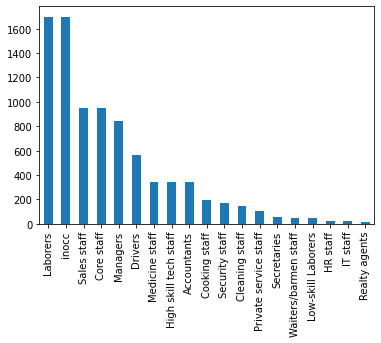

In [116]:
fill_data_t['occyp_type'].value_counts().plot(kind='bar')

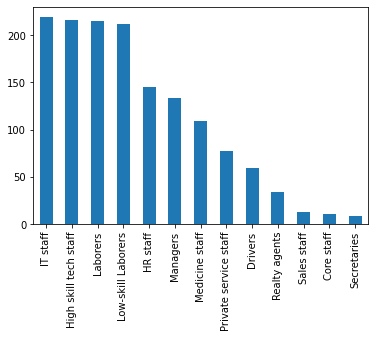

In [117]:
null_data_t['occyp_type'].value_counts().plot(kind='bar')

In [118]:
fill_data_t=fill_data_t.drop('occyp_type_l',axis=1)

In [119]:
df_t=pd.concat([null_data_t,fill_data_t]).sort_values(by='index')
df_t.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,1,1,0,0,112500.0,1,4,0,1,-21990,0,1,0,1,0,inocc,2.0,-60.0
1,26458,0,0,1,0,135000.0,2,1,1,1,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,0,0,1,0,69372.0,4,4,1,1,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,1,1,0,0,112500.0,0,4,1,1,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,0,1,1,0,225000.0,2,1,1,1,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


## 모델링

In [120]:
data=df.copy()
data=data.drop('employeed',axis=1)
data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709,1,0,0,0,IT staff,2.0,-6.0,1.0
1,1,0,0,1,1,247500.0,0,4,0,1,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,1,1,1,0,450000.0,4,1,1,1,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,0,0,1,0,202500.0,0,4,1,1,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,0,1,1,0,157500.0,2,1,1,1,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [121]:
data['occyp_type']=label_encoder.fit_transform(data['occyp_type'])
data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709,1,0,0,0,7,2.0,-6.0,1.0
1,1,0,0,1,1,247500.0,0,4,0,1,-11380,-1540,1,0,0,1,8,3.0,-5.0,1.0
2,2,1,1,1,0,450000.0,4,1,1,1,-19087,-4434,1,0,1,0,10,2.0,-22.0,2.0
3,3,0,0,1,0,202500.0,0,4,1,1,-15088,-2092,1,0,1,0,14,2.0,-37.0,0.0
4,4,0,1,1,0,157500.0,2,1,1,1,-15037,-2105,1,0,0,0,10,2.0,-26.0,2.0


In [122]:
train_x=data.drop(['credit','index'],axis=1)
train_y=data[['credit']]
print(train_x.shape,train_y.shape)

(26457, 18) (26457, 1)


In [123]:
train_x.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709,1,0,0,0,7,2.0,-6.0
1,0,0,1,1,247500.0,0,4,0,1,-11380,-1540,1,0,0,1,8,3.0,-5.0
2,1,1,1,0,450000.0,4,1,1,1,-19087,-4434,1,0,1,0,10,2.0,-22.0
3,0,0,1,0,202500.0,0,4,1,1,-15088,-2092,1,0,1,0,14,2.0,-37.0
4,0,1,1,0,157500.0,2,1,1,1,-15037,-2105,1,0,0,0,10,2.0,-26.0


In [124]:
test_x=df_t.copy()

In [125]:
test_x['occyp_type']=label_encoder.fit_transform(test_x['occyp_type'])
test_x.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,1,1,0,0,112500.0,1,4,0,1,-21990,0,1,0,1,0,18,2.0,-60.0
1,26458,0,0,1,0,135000.0,2,1,1,1,-18964,-8671,1,0,1,0,3,2.0,-36.0
2,26459,0,0,1,0,69372.0,4,4,1,1,-15887,-217,1,1,1,0,8,2.0,-40.0
3,26460,1,1,0,0,112500.0,0,4,1,1,-19270,-2531,1,1,0,0,4,2.0,-41.0
4,26461,0,1,1,0,225000.0,2,1,1,1,-17822,-9385,1,1,0,0,10,2.0,-8.0


In [126]:
test_x=test_x.drop('index',axis=1)
test_x.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,1,1,0,0,112500.0,1,4,0,1,-21990,0,1,0,1,0,18,2.0,-60.0
1,0,0,1,0,135000.0,2,1,1,1,-18964,-8671,1,0,1,0,3,2.0,-36.0
2,0,0,1,0,69372.0,4,4,1,1,-15887,-217,1,1,1,0,8,2.0,-40.0
3,1,1,0,0,112500.0,0,4,1,1,-19270,-2531,1,1,0,0,4,2.0,-41.0
4,0,1,1,0,225000.0,2,1,1,1,-17822,-9385,1,1,0,0,10,2.0,-8.0


In [127]:
print(train_x.shape,test_x.shape,train_y.shape)

(26457, 18) (10000, 18) (26457, 1)


### Xgboost

In [128]:
sc = StandardScaler()#표준화
x_train_df=train_x.copy()
y_train_df=train_y.copy()

X=x_train_df.values
Y=y_train_df.values

x_train = sc.fit_transform(X)

In [129]:
print(x_train[0])

[-0.70356176 -0.78246318 -1.43762552 -0.5735993   0.1491363  -1.37957168
 -1.56352825 -0.38558347  0.76270405  0.49007478 -1.05922745  0.
 -0.53841734 -0.64570461 -0.31693724 -0.45379047 -0.21473529  1.21523077]


In [130]:
x_test=test_x.copy()
x_test=x_test.values
x_test=sc.transform(x_test)

In [131]:
x_test[0]

array([ 1.42133933,  1.27801541, -1.43762552, -0.5735993 , -0.73428677,
       -0.80349087,  0.67264734, -1.43543237, -0.29633138, -1.43566162,
        0.92761212,  0.        , -0.53841734,  1.54869577, -0.31693724,
        1.60333314, -0.21473529, -2.04578904])

### 표준화

In [132]:
X_train, X_val, y_train, y_val = train_test_split(x_train, train_y, 
                                                    stratify=train_y, test_size=0.25)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

xgb=XGBClassifier(n_estimators=1000)
xgb.fit(x_train,train_y)

y_pred=xgb.predict_proba(X_val) 

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 18)
(19842, 1)
Validation set: 
(6615, 18)
(6615, 1)
log_loss: 0.6656666722385183


In [133]:
#xgboost(표준화)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
        
outcomes = []
sub = np.zeros((test_x.shape[0],3))
for n_fold, (train_index, val_index)  in enumerate(folds.split(x_train, train_y)):
    X_train, X_val = x_train[train_index], x_train[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    xgb=XGBClassifier(n_estimators=1000)
    xgb.fit(X_train, y_train)
    predictions = xgb.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(y_val)

    sub += xgb.predict_proba(x_test)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)

In [134]:
print(np.mean(outcomes))

0.7553833064055759


### 표준화x

In [135]:
#xgboost(표준화x)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
        
outcomes = []
sub = np.zeros((test_x.shape[0],3))
for n_fold, (train_index, val_index)  in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    xgb=XGBClassifier(n_estimators=1000)
    xgb.fit(X_train, y_train)
    predictions = xgb.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(y_val)

    sub += xgb.predict_proba(test_x)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)

sub = sub / 5
xg_sc_logloss=np.mean(outcomes)
print(xg_sc_logloss) 

0.7554024456171665


## LightGBM

In [136]:
#표준화x
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,stratify=train_y, test_size=0.25) 
                                                    
print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

lgbm = LGBMClassifier(n_estimators=1000)
lgbm.fit(X_train, y_train)
y_pred=lgbm.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 18)
(19842, 1)
Validation set: 
(6615, 18)
(6615, 1)
log_loss: 0.7844594773149419


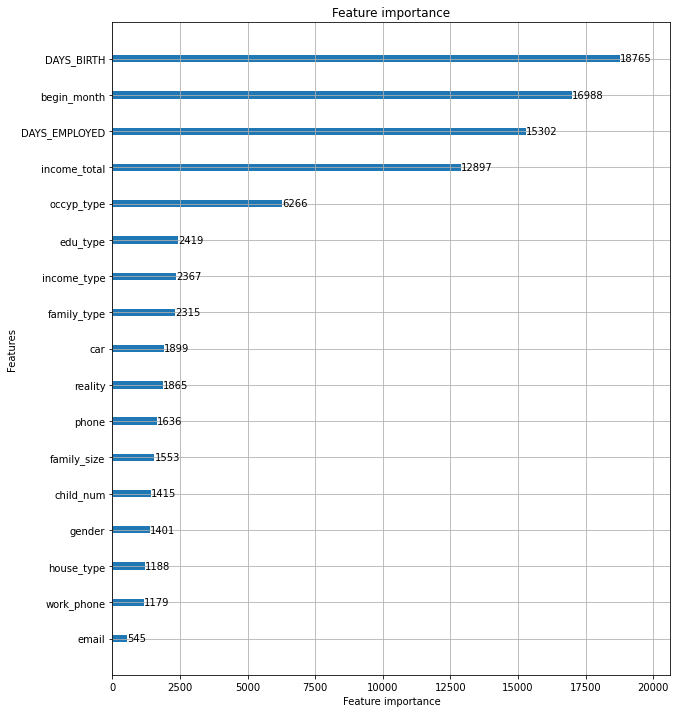

In [137]:
fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm,ax=ax)

In [138]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
        
outcomes = []
sub = np.zeros((test_x.shape[0],3))
for n_fold, (train_index, val_index)  in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    lgbm = LGBMClassifier(n_estimators=1000)
    lgbm.fit(X_train, y_train)
    predictions = lgbm.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(y_val)

    sub += lgbm.predict_proba(test_x)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)

sub = sub / 5
   
lg_logloss=np.mean(outcomes)#logloss의 평균
print(lg_logloss)

0.7606538038198354


In [139]:
#표준화 후
X_train, X_val, y_train, y_val = train_test_split(x_train, train_y,stratify=train_y, test_size=0.25) 
                                                    
print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

lgbm = LGBMClassifier(n_estimators=1000)
lgbm.fit(X_train, y_train)
y_pred=lgbm.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 18)
(19842, 1)
Validation set: 
(6615, 18)
(6615, 1)
log_loss: 0.7576690269982873


In [140]:
#lightgbm
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
        
outcomes = []
sub = np.zeros((test_x.shape[0],3))
for n_fold, (train_index, val_index)  in enumerate(folds.split(x_train, train_y)):
    X_train, X_val = x_train[train_index], x_train[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    lgbm = LGBMClassifier(n_estimators=1000)
    lgbm.fit(X_train, y_train)
    predictions = lgbm.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(y_val)

    sub += lgbm.predict_proba(x_test)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)

sub = sub / 5

In [141]:
lg_sc_logloss=np.mean(outcomes)#logloss의 평균

In [142]:
print(lg_sc_logloss)

0.7607206584935557


- XGBoost: 표준화(0.7553833064055759), 비표준화(0.7554024456171665) -nfold 기준
- LightGBM: 표준화(0.7606538038198354), 피표준화(0.7607206584935557) -nfold 기준
